In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
# some imports 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # this is used for the plot the graph 
import os
import seaborn as sns # used for plot interactive graph.
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import sklearn.metrics.cluster as smc
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


from matplotlib import pyplot
import itertools

%matplotlib inline

import random 

In [ ]:
%cd /content/drive/My\ Drive/Colab\ Notebooks/CS188
# %cd /content/sample_data
%ls

/content/drive/My Drive/Colab Notebooks/CS188
 score_V3.csv           training_dataset_V3.csv
 training_dataset.csv  'UCLA CS188 Project 3 Writeup.pdf'


In [ ]:
data = pd.read_csv("training_dataset_V3.csv")
score = pd.read_csv("score_V3.csv")
#data = pd.read_csv("score.csv")
data.head()
score.info()
#data.describe()
score.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                1000 non-null   int64  
 1   dt                        1000 non-null   object 
 2   weekday                   1000 non-null   object 
 3   year                      1000 non-null   int64  
 4   id_driver                 1000 non-null   int64  
 5   id_carrier_number         1000 non-null   object 
 6   dim_carrier_type          1000 non-null   object 
 7   dim_carrier_company_name  1000 non-null   object 
 8   home_base_city            1000 non-null   object 
 9   home_base_state           1000 non-null   object 
 10  carrier_trucks            1000 non-null   object 
 11  num_trucks                1000 non-null   float64
 12  interested_in_drayage     1000 non-null   object 
 13  port_qualified            1000 non-null   object 
 14  signup_so

,Unnamed: 0,year,id_driver,num_trucks,days_signup_to_approval,loads,marketplace_loads_otr,marketplace_loads_atlas,marketplace_loads,brokerage_loads_otr,brokerage_loads_atlas,brokerage_loads
count,1000.000000,1000.000000,1000.000000,1000.000000,854.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,83913.500000,2018.938000,18047.613000,23.786000,303.025761,2.009000,30.633000,68.849000,99.482000,139.969000,13.441000,153.410000
std,288.819436,1.400756,11886.925434,49.731896,396.369014,2.097455,96.460432,190.030286,214.564073,370.005232,44.422741,368.057722
min,83414.000000,2015.000000,33.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,83663.750000,2018.000000,7717.250000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
50%,83913.500000,2019.000000,16264.500000,4.000000,59.000000,1.000000,2.000000,0.000000,13.000000,13.500000,0.000000,35.000000
75%,84163.250000,2020.000000,28974.000000,15.000000,497.000000,2.000000,22.000000,18.000000,88.000000,109.250000,1.000000,131.500000
max,84413.000000,2021.000000,37962.000000,195.000000,1561.000000,27.000000,902.000000,1324.000000,1348.000000,2671.000000,371.000000,2671.000000


In [ ]:
# 1. generate labels

loads_75 = data["total_loads"].quantile(0.75)

# process dates
data['most_recent_load_date'] =  pd.to_datetime(data['most_recent_load_date'])
today = pd.to_datetime("today")
data["most_recent_load_days"] = data['most_recent_load_date'] - today
date_75 = data["most_recent_load_days"].quantile(0.75)
print(date_75)

data["new_label"] = ((data["total_loads"] >= loads_75) & (data["most_recent_load_days"] >= date_75)).astype(int)
data.info()

-33 days +07:49:29.852491
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83414 entries, 0 to 83413
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype          
---  ------                    --------------  -----          
 0   Unnamed: 0                83414 non-null  int64          
 1   dt                        83414 non-null  object         
 2   weekday                   83414 non-null  object         
 3   year                      83414 non-null  int64          
 4   id_driver                 83414 non-null  int64          
 5   id_carrier_number         83414 non-null  object         
 6   dim_carrier_type          83414 non-null  object         
 7   dim_carrier_company_name  83365 non-null  object         
 8   home_base_city            83369 non-null  object         
 9   home_base_state           83369 non-null  object         
 10  carrier_trucks            83414 non-null  object         
 11  num_trucks                83344 non-null 

In [ ]:
score.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                1000 non-null   int64  
 1   dt                        1000 non-null   object 
 2   weekday                   1000 non-null   object 
 3   year                      1000 non-null   int64  
 4   id_driver                 1000 non-null   int64  
 5   id_carrier_number         1000 non-null   object 
 6   dim_carrier_type          1000 non-null   object 
 7   dim_carrier_company_name  1000 non-null   object 
 8   home_base_city            1000 non-null   object 
 9   home_base_state           1000 non-null   object 
 10  carrier_trucks            1000 non-null   object 
 11  num_trucks                1000 non-null   float64
 12  interested_in_drayage     1000 non-null   object 
 13  port_qualified            1000 non-null   object 
 14  signup_so

Concatenating both data and scores together

In [ ]:
frames = [data, score]
data = pd.concat(frames)
data.info()
data.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84414 entries, 0 to 999
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype          
---  ------                    --------------  -----          
 0   Unnamed: 0                84414 non-null  int64          
 1   dt                        84414 non-null  object         
 2   weekday                   84414 non-null  object         
 3   year                      84414 non-null  int64          
 4   id_driver                 84414 non-null  int64          
 5   id_carrier_number         84414 non-null  object         
 6   dim_carrier_type          84414 non-null  object         
 7   dim_carrier_company_name  84365 non-null  object         
 8   home_base_city            84369 non-null  object         
 9   home_base_state           84369 non-null  object         
 10  carrier_trucks            84414 non-null  object         
 11  num_trucks                84344 non-null  float64        
 12  intere

,Unnamed: 0,dt,weekday,year,id_driver,id_carrier_number,dim_carrier_type,dim_carrier_company_name,home_base_city,home_base_state,carrier_trucks,num_trucks,interested_in_drayage,port_qualified,signup_source,ts_signup,ts_first_approved,days_signup_to_approval,driver_with_twic,dim_preferred_lanes,first_load_date,most_recent_load_date,load_day,loads,marketplace_loads_otr,marketplace_loads_atlas,marketplace_loads,brokerage_loads_otr,brokerage_loads_atlas,brokerage_loads,total_loads,most_recent_load_days,new_label
995,84409,2018-09-22,Saturday,2018,597,C0090094,Fleet,MC Express Trucking LLC,Rosarito,B.C.,"[""dryvan""]",101.0,not specified,no,Other,2016-03-09 20:56:40+00:00,2019-02-22 16:56:58+00:00,1079.0,no,NaN,2016-04-15,NaT,2018-09-22,1,0,0,0,62,0,62,NaN,NaT,NaN
996,84410,2020-07-02,Thursday,2020,32167,U0119262,Owner Operator,Lagosian Transport,Compton,CA,"[""poweronly""]",1.0,not specified,no,Mobile,2019-12-31 21:32:50+00:00,2020-01-09 00:43:58+00:00,8.0,no,NaN,2020-02-04,NaT,2020-07-02,2,38,267,305,2,19,21,NaN,NaT,NaN
997,84411,2018-06-27,Wednesday,2018,7054,U0096411,Owner Operator,pioneer transport,San Bernardino,CA,"[""dryvan""]",1.0,not specified,no,Other,2017-07-11 22:31:31+00:00,2019-10-03 17:52:13+00:00,813.0,no,NaN,2018-04-16,NaT,2018-06-27,1,19,5,24,11,0,11,NaN,NaT,NaN
998,84412,2017-03-21,Tuesday,2017,638,C0090094,Fleet,MC Express Trucking LLC,Rosarito,B.C.,"[""dryvan""]",101.0,not specified,no,Other,2016-03-09 20:56:40+00:00,2019-02-22 16:56:58+00:00,1079.0,no,NaN,2016-04-04,NaT,2017-03-21,1,0,0,0,119,0,119,NaN,NaT,NaN
999,84413,2020-11-07,Saturday,2020,33543,C0093828,Fleet,CR TRANSPORTATION,San Bernardino,CA,"[""dryvan""]",10.0,yes,no,Other,2018-12-13 19:49:00+00:00,2018-12-13 19:49:29+00:00,0.0,no,NaN,2020-03-05,NaT,2020-11-07,1,4,6,10,73,0,73,NaN,NaT,NaN


In [ ]:
# 2.
#First dropping various columns

#note: possibly add home_base_city
%load_ext google.colab.data_table

df_drop = data.drop(["weekday","dt", "loads", "most_recent_load_date", "Unnamed: 0","year","id_driver","id_carrier_number","dim_carrier_company_name","home_base_city", "ts_first_approved", "dim_preferred_lanes", "ts_signup", "most_recent_load_days", "total_loads"], axis=1)
#drop rows with null num_trucks and home_base_state

df_row_drop2 = df_drop.dropna(subset=["num_trucks", "home_base_state"])
df_row_drop2.info()


#clustering days_signup_to_approval into 3 categories
approval_conditions = [
      (df_row_drop2["days_signup_to_approval"] <= 63.0),
      (df_row_drop2["days_signup_to_approval"] > 63.0) & (df_row_drop2["days_signup_to_approval"] <= 1653.0),
      (np.isnan(df_row_drop2["days_signup_to_approval"]))
]
approval_tiers = ["Low", "High", "Not approved"]
df_row_drop2["approval_tier"] = np.select(approval_conditions, approval_tiers)
df_row_drop3 = df_row_drop2.drop("days_signup_to_approval", axis=1)

#carrier_trucks, create a separate column for each category
attributes = ["dryvan", "boxtruck", "poweronly", "reefer", "flatbed"]
for attribute in attributes: 
  df_row_drop3[attribute] = df_row_drop3["carrier_trucks"].str.contains(attribute).astype(int)

df_row_drop4 = df_row_drop3.drop("carrier_trucks", axis=1)
today = pd.to_datetime("today")
df_row_drop4["first_load_date"] = (pd.to_datetime(df_row_drop4["first_load_date"]) - today).astype(int)
df_row_drop4["load_day"] = (pd.to_datetime(df_row_drop4["load_day"]) - today).astype(int)
df_row_drop4

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84300 entries, 0 to 999
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   dim_carrier_type         84300 non-null  object 
 1   home_base_state          84300 non-null  object 
 2   carrier_trucks           84300 non-null  object 
 3   num_trucks               84300 non-null  float64
 4   interested_in_drayage    84300 non-null  object 
 5   port_qualified           84300 non-null  object 
 6   signup_source            84300 non-null  object 
 7   days_signup_to_approval  71926 non-null  float64
 8   driver_with_twic         84300 non-null  object 
 9   first_load_date          84300 non-null  object 
 10  load_day                 84300 non-null  object 
 11  marketplace_loads_otr    84300 non-null  int64  
 12  marketplace_loads_atlas  84300 non-null  int64  
 13  marketplace_loads        84300 non-null  int64  
 14  brokerage_loads_otr     

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,dim_carrier_type,home_base_state,num_trucks,interested_in_drayage,port_qualified,signup_source,driver_with_twic,first_load_date,load_day,marketplace_loads_otr,marketplace_loads_atlas,marketplace_loads,brokerage_loads_otr,brokerage_loads_atlas,brokerage_loads,new_label,approval_tier,dryvan,boxtruck,poweronly,reefer,flatbed
0,Owner Operator,CA,1.0,yes,yes,Other,yes,-44208640075058000,-39629440075058000,0,438,438,0,45,45,1.0,Low,0,0,1,0,0
1,Fleet,CA,15.0,yes,yes,Mobile,no,-13450240075058000,-5415040075058000,2,72,74,0,1,1,0.0,Low,0,1,1,0,0
2,Owner Operator,CA,1.0,yes,yes,Other,yes,-39975040075058000,-38765440075058000,0,180,180,0,2,2,0.0,High,0,0,1,0,0
3,Fleet,CA,195.0,yes,yes,Other,yes,-23645440075058000,-3168640075058000,0,0,0,0,0,0,0.0,Low,1,0,1,0,0
4,Owner Operator,CA,1.0,not specified,no,Other,no,-131472640075058000,-115229440075058000,57,0,57,314,0,314,0.0,High,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Fleet,B.C.,101.0,not specified,no,Other,no,-155405440075058000,-78509440075058000,0,0,0,62,0,62,NaN,High,1,0,0,0,0
996,Owner Operator,CA,1.0,not specified,no,Mobile,no,-35309440075058000,-22435840075058000,38,267,305,2,19,21,NaN,Low,0,0,1,0,0
997,Owner Operator,CA,1.0,not specified,no,Other,no,-92247040075058000,-86026240075058000,19,5,24,11,0,11,NaN,High,1,0,0,0,0
998,Fleet,B.C.,101.0,not specified,no,Other,no,-156355840075058000,-126029440075058000,0,0,0,119,0,119,NaN,High,1,0,0,0,0


In [ ]:
df_unprepared = df_row_drop4.drop(["new_label"], axis=1)

In [ ]:
#Implementing sklearn pipeline, scales data and one-hot encodes
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.base import BaseEstimator, TransformerMixin


#imputer = SimpleImputer(strategy="median") # use median imputation for missing values
df_num = df_unprepared.drop(["dim_carrier_type", "home_base_state", "interested_in_drayage", "port_qualified", "signup_source", "driver_with_twic", "approval_tier"], axis=1) # remove the categorical feature
# column index

num_pipeline = Pipeline([
        #('imputer', SimpleImputer(strategy="median")),
        #('attribs_adder', AugmentFeatures()),
        ('std_scaler', StandardScaler()),
    ])

numerical_features = list(df_num)
categorical_features = ["dim_carrier_type", "home_base_state", "interested_in_drayage", "port_qualified", "signup_source", "driver_with_twic", "approval_tier"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, numerical_features),
        ("cat", OneHotEncoder(), categorical_features),
    ])

df_prepared = full_pipeline.fit_transform(df_unprepared)
#score_prepared = full_pipeline.fit_transform(scores)

In [ ]:
#Splits the data back into the original train and test data
from sklearn.model_selection import train_test_split
data_train, score_test= train_test_split(df_prepared, train_size=83300, shuffle=False)
print(df_prepared.shape)
print(data_train.shape)

(84300, 67)
(83300, 67)


In [ ]:
from sklearn.model_selection import train_test_split
data_target = df_row_drop4['new_label']
data_target = data_target.dropna()
print(data_target)
#print(data_target.shape)
#print(data_train.shape)
#train, test, target, target_test = train_test_split(df_prepared, data_target, test_size=0.3, random_state=0)
train, test, target, target_test = train_test_split(data_train, data_target, test_size=0.3, random_state=0)

0        1.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
83409    1.0
83410    0.0
83411    0.0
83412    0.0
83413    1.0
Name: new_label, Length: 83300, dtype: float64


In [ ]:
# 5. Logistic Regression

from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver = 'liblinear')
log_reg.fit(train,target)
predicted_log = log_reg.predict(test)
print("Accuracy for logistic regression :", metrics.accuracy_score(target_test,predicted_log))
print(log_reg.coef_)

Accuracy for logistic regression : 0.9148459383753501
[[-6.07299935e+00 -1.42782045e-01  1.07656007e+00  2.07099213e-01
   6.36681218e-01  6.62516297e-01  4.74061444e-01  2.42244817e-01
   5.01349401e-01  4.39349733e-01  2.30351774e-01  1.64417454e-01
  -4.53032910e-01 -1.51842988e-01 -8.19017572e-01 -7.72476212e-01
  -1.07958351e-01  2.95955652e+00 -7.61579031e-01 -5.35783606e-03
   2.86502692e-01 -8.27648315e-02 -7.86223812e-03 -2.10180887e-02
  -1.25757939e+00 -5.48415240e-01 -8.18523080e-03 -5.58249170e-03
   3.91788394e+00 -3.07038368e-01 -7.89245373e-03 -1.18018753e-01
   0.00000000e+00 -1.09837484e-01 -4.34347111e-02 -1.21906717e-01
  -6.55366516e-02 -1.27834372e-03 -9.17267514e-03 -5.39018582e-02
  -8.97155084e-01 -4.30830742e-03 -1.32448184e+00 -2.75878900e-01
  -2.35294466e-01 -2.81446630e-02 -3.76583168e-01 -1.43068255e-01
  -9.95731623e-04 -1.38702254e-02 -9.15302281e-01 -9.48396094e-02
   0.00000000e+00 -2.12917849e-01 -1.93624364e-02 -5.68913391e-01
  -9.63854010e-01 -6.2

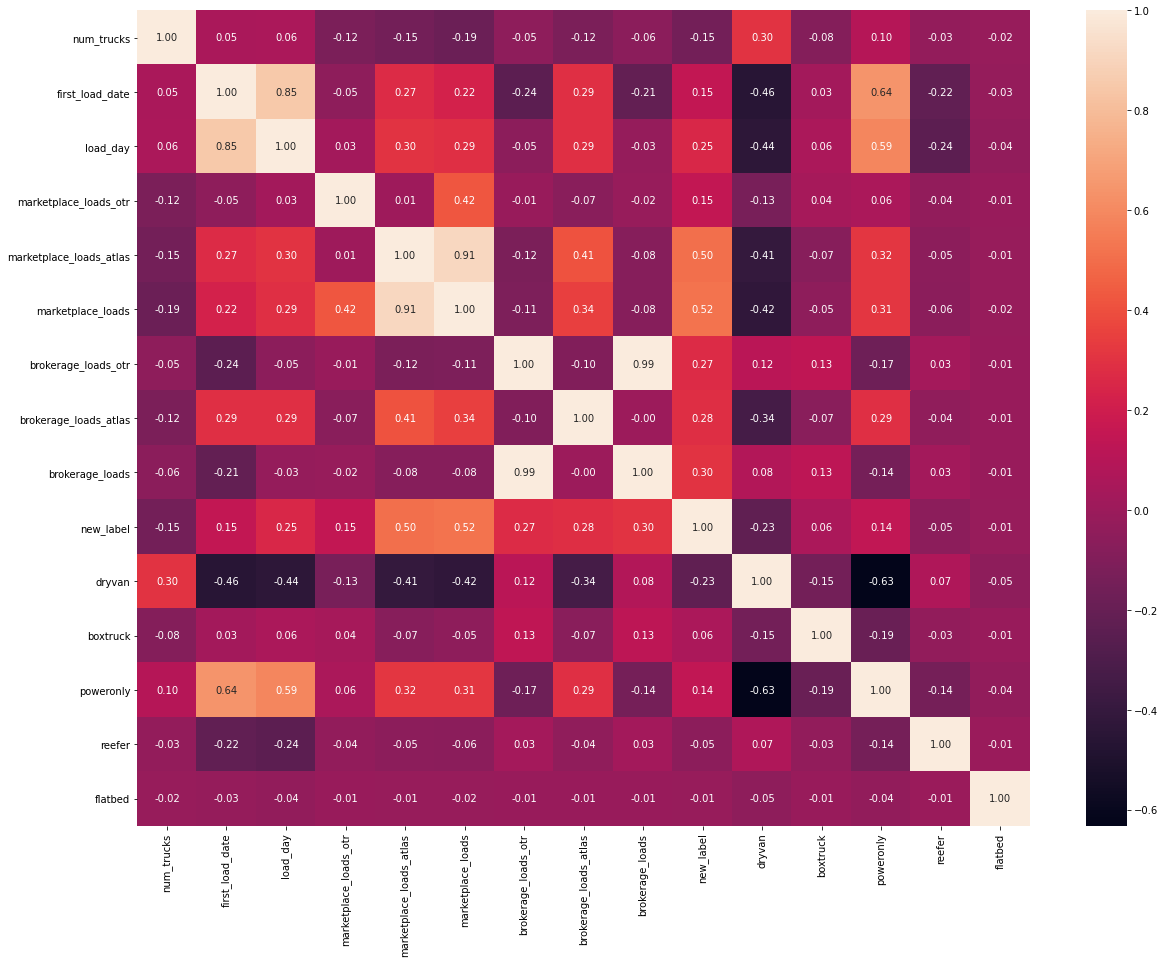

In [ ]:
fig,ax = plt.subplots(figsize=(20,15))
sns.heatmap(df_row_drop4.corr(), annot=True, fmt='.2f')

In [ ]:
# 6. PCA
from sklearn.decomposition import PCA
print(df_prepared.shape)
#print(data_train.shape)
#print(data_train)
# tune

for i in range(df_prepared.shape[1]):
  pca = PCA(n_components = i)
  X_new = pca.fit_transform(df_prepared)
  if sum(pca.explained_variance_ratio_) >= 0.99:
    break


'''
for i in range(data_train.shape[1]):
  pca = PCA(n_components = i)
  X_new = pca.fit_transform(data_train)
  if sum(pca.explained_variance_ratio_) >= 0.99:
    break
'''
print(f"PCA number of components: {pca.n_components_}")
print(sum(pca.explained_variance_ratio_))

data_train, score_test= train_test_split(X_new, train_size=83300, shuffle=False)
#train, test, target, target_test = train_test_split(X_new, data_target, test_size=0.3, random_state=0)
train, test, target, target_test = train_test_split(data_train, data_target, test_size=0.3, random_state=0)

(84300, 67)
PCA number of components: 18
0.9914903406066897


In [ ]:
# 7. Ensemble - RF
from collections import OrderedDict
from itertools import product
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few tre

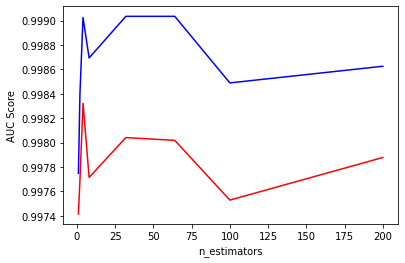

In [ ]:
n_estimators = [1,2,4,8,32,64,100,200]
results = {}
train_results = []
test_results = []
for ntrees in n_estimators:
    est = RandomForestClassifier(oob_score=True, 
          n_estimators=ntrees, max_features=0.5, min_samples_leaf = 10, max_depth=10, n_jobs=-1, random_state=0)
    est.fit(train, target)
    fpr, tpr, thresholds = roc_curve(target, est.predict(train))
    roc_auc = auc(fpr, tpr)
    train_results.append(roc_auc)
    fpr, tpr, thresholds = roc_curve(target_test, est.predict(test))
    roc_auc = auc(fpr, tpr)
    test_results.append(roc_auc)
    
    
line1, = plt.plot(n_estimators, train_results, 'b', label="Train AUC")
line2, = plt.plot(n_estimators, test_results, 'r', label = "Test AUC")
plt.ylabel('AUC Score')
plt.xlabel('n_estimators')
plt.show()
ntrees = 30

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few tre

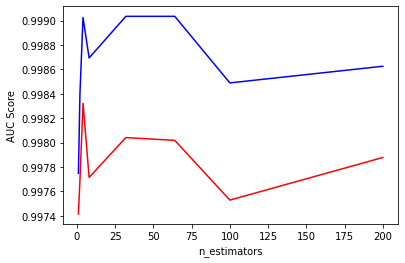

In [ ]:
#Varying number of trees
n_estimators = [1,2,4,8,32,64,100,200]
results = {}
train_results = []
test_results = []
for ntrees in n_estimators:
    est = RandomForestClassifier(oob_score=True, 
          n_estimators=ntrees, max_features=0.5, min_samples_leaf = 10, max_depth=10, n_jobs=-1, random_state=0)
    est.fit(train, target)
    fpr, tpr, thresholds = roc_curve(target, est.predict(train))
    roc_auc = auc(fpr, tpr)
    train_results.append(roc_auc)
    fpr, tpr, thresholds = roc_curve(target_test, est.predict(test))
    roc_auc = auc(fpr, tpr)
    test_results.append(roc_auc)
    
    
line1, = plt.plot(n_estimators, train_results, 'b', label="Train AUC")
line2, = plt.plot(n_estimators, test_results, 'r', label = "Test AUC")
plt.ylabel('AUC Score')
plt.xlabel('n_estimators')
plt.show()
ntrees = 30

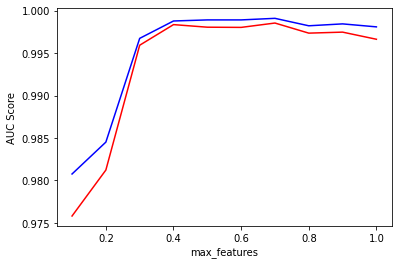

In [ ]:
#Varying max features to split between
max_features = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for maxf in max_features:
    est = RandomForestClassifier(oob_score=True, 
          n_estimators=30, max_features=maxf, min_samples_leaf = 10, max_depth=10, n_jobs=-1, random_state=0)
    est.fit(train, target)
    fpr, tpr, thresholds = roc_curve(target, est.predict(train))
    roc_auc = auc(fpr, tpr)
    train_results.append(roc_auc)
    fpr, tpr, thresholds = roc_curve(target_test, est.predict(test))
    roc_auc = auc(fpr, tpr)
    results[ntrees] = roc_auc
    test_results.append(roc_auc)
    
    
line1, = plt.plot(max_features, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_features, test_results, 'r', label = "Test AUC")
plt.ylabel('AUC Score')
plt.xlabel('max_features')
plt.show()
max_features = 0.2

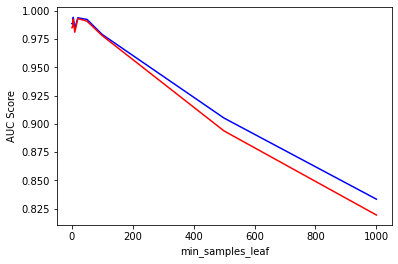

In [ ]:
#Varying min samples per leaf
min_samples_leaf = [1,2,3,4,5,10,20,50,100,500,1000]
train_results = []
test_results = []
for minlf in min_samples_leaf:
    est = RandomForestClassifier(oob_score=True, 
          n_estimators=30, max_features=0.2, min_samples_leaf = minlf, max_depth=10, n_jobs=-1, random_state=0)
    est.fit(train, target)
    fpr, tpr, thresholds = roc_curve(target, est.predict(train))
    roc_auc = auc(fpr, tpr)
    train_results.append(roc_auc)
    fpr, tpr, thresholds = roc_curve(target_test, est.predict(test))
    roc_auc = auc(fpr, tpr)
    test_results.append(roc_auc)
    
    
line1, = plt.plot(min_samples_leaf, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_leaf, test_results, 'r', label = "Test AUC")
plt.ylabel('AUC Score')
plt.xlabel('min_samples_leaf')
plt.show()
min_samples_leaf = 2

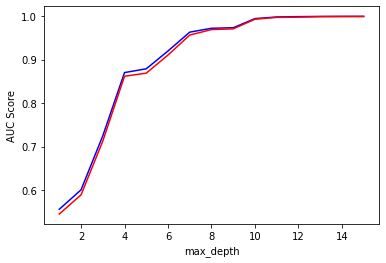

In [ ]:
#Varying max depth
max_depth = np.linspace(1, 15, 15, endpoint=True)
train_results = []
test_results = []
for maxdp in max_depth:
    est = RandomForestClassifier(oob_score=True, 
          n_estimators=25, max_features=0.2, min_samples_leaf = 5, max_depth=maxdp, n_jobs=-1, random_state=0)
    est.fit(train, target)
    fpr, tpr, thresholds = roc_curve(target, est.predict(train))
    roc_auc = auc(fpr, tpr)
    train_results.append(roc_auc)
    fpr, tpr, thresholds = roc_curve(target_test, est.predict(test))
    roc_auc = auc(fpr, tpr)
    test_results.append(roc_auc)
    
    
line1, = plt.plot(max_depth, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depth, test_results, 'r', label = "Test AUC")
plt.ylabel('AUC Score')
plt.xlabel('max_depth')
plt.show()
max_depth = 10

In [ ]:
# 7 - RF
ntrees = 30
max_depth = 10
min_samples_leaf = 2
max_features = 0.2
est = RandomForestClassifier(oob_score=True, 
          n_estimators=ntrees, max_features=max_features, min_samples_leaf = min_samples_leaf, max_depth=max_depth, n_jobs=-1, random_state=0)
est.fit(train, target)
fpr, tpr, thresholds = roc_curve(target_test, est.predict(test))
roc_auc = auc(fpr, tpr)
print(roc_auc)
print(est.score(test, target_test))

0.9853085210577865
0.9963985594237695


In [ ]:
#8 - NN
#varying number of nodes in hidden layer
from sklearn.neural_network import MLPClassifier
num_nodes = [2,10,20,100,200,500,1000]
for i in num_nodes:
  nn = MLPClassifier(hidden_layer_sizes=i)
  nn.fit(train, target)
  print("Score for ", i, " nodes: ",nn.score(test, target_test))

Score for  2  nodes:  0.946858743497399


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Score for  10  nodes:  0.9948779511804722
Score for  20  nodes:  0.9996798719487795
Score for  100  nodes:  0.9997599039615847
Score for  200  nodes:  0.9996798719487795
Score for  500  nodes:  0.9996798719487795
Score for  1000  nodes:  1.0


In [ ]:
#NN - varying learning rate
learning_rate = [.0005, .001, .002, .005, .01]
for i in learning_rate:
  nn = MLPClassifier(learning_rate_init=i)
  nn.fit(train, target)
  print("Score for learning rate of ", i, ": ",nn.score(test, target_test))

Score for learning rate of  0.0005 :  0.9997599039615847
Score for learning rate of  0.001 :  1.0
Score for learning rate of  0.002 :  1.0
Score for learning rate of  0.005 :  1.0
Score for learning rate of  0.01 :  1.0


In [ ]:
#9 - Cross Validation
from sklearn.model_selection import cross_val_score
RF_scores = cross_val_score(est, test, target_test, cv=10)
print("RF: %0.5f accuracy with a standard deviation of %0.5f" % (RF_scores.mean(), RF_scores.std()))


RF: 0.99796 accuracy with a standard deviation of 0.00119


In [ ]:
#final model, includes cross-validation
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(hidden_layer_sizes=100, learning_rate_init=.001)
nn.fit(train, target)
print("Score: ",nn.score(test, target_test))
NN_scores = cross_val_score(nn, test, target_test, cv=5)
print("NN: %0.5f accuracy with a standard deviation of %0.5f" % (NN_scores.mean(), NN_scores.std()))

Score:  0.9996798719487795


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


NN: 0.99116 accuracy with a standard deviation of 0.00908


In [ ]:
#printing out the predictions
results = nn.predict(score_test)
print(results)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [ ]:
#10 - Custom Models

print("None needed, the NN perfomed so well")

None needed, the NN perfomed so well


In [ ]:
#generating the submission file
import csv  
# field names  
fields = ['Id', 'Predicted']  
ids = [*range(83414, 84414)]

predictions = results


# data rows of csv file  
# name of csv file  
filename = "submission.csv"
# writing to csv file  

with open(filename, 'w') as csvfile:  
    # creating a csv writer object  
    csvwriter = csv.writer(csvfile)  
    # writing the fields  
    csvwriter.writerow(fields)  
        
    # writing the data rows  
    for i in range(1000):
      item = [ids[i], int(predictions[i])]
      csvwriter.writerow(item)
